In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import KMeans
import re
import pathlib
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
pca = PCA(n_components=2)
reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='euclidean', random_state=42)

dose_rates = [0.0, 0.004, 0.04, 0.4, 4.0, 8.0]
#colors = ['black', 'red', 'orange', 'green', 'blue', 'purple']
colors = ['black', 'red', 'red', 'red', 'blue', 'purple']

weeks = np.arange(1,10)
color_map = dict(zip(dose_rates, colors))

df = pd.read_csv("/homes/shahashka/lucid_cd/data/rpe1_experiment2/cd_tpm_matrix_combined_dose_rate.csv", header=0)
df_genes = df.drop(columns=["dose_rate", "week"])
df_genes.to_csv("/homes/shahashka/lucid_cd/data/rpe1_experiment2/cd_tpm_matrix_combined.csv", index=False)
#cumulative_dose = df['dose_rate']*df['week']*168 #hr/week
print(df.shape, 'dose_rate' in df.columns)


(108, 11898) True


## Preprocessing and visualization

In [84]:
def pca_plot(df, genes, axs):
    pca_2d = pca.fit_transform(df[genes])
    plt.figure(figsize=(8,6))
    axs[0].scatter(pca_2d[:,0], pca_2d[:,1], c=[color_map[dr] for dr in df['dose_rate']])
    axs[1].scatter(pca_2d[:,0], pca_2d[:,1],  c=df['week'], cmap='Blues')

    for ax in axs:
        ax.set_title("PCA")
        ax.set_xlabel("component 1")
        ax.set_ylabel("component 2")
        ax.grid(True)
    
def umap_plot(df, genes, axs):
    embedding_2d = reducer.fit_transform(df[genes])
    # kmeans = KMeans(n_clusters=3)
    # cluster_ids = kmeans.fit_predict(embedding_2d)

    axs[0].scatter(embedding_2d[:,0], embedding_2d[:,1],c=[color_map[dr] for dr in df['dose_rate']]) # alpha=df['week']/10,
    axs[1].scatter(embedding_2d[:,0], embedding_2d[:,1], c=df['week'], cmap='Blues')
    week4 = [ i for i in range(df['week'].shape[0]) if df['week'].iloc[i] == 4]
    axs[1].scatter(embedding_2d[:,0][week4], embedding_2d[:,1][week4], c='red')

    #plt.scatter(embedding_2d[:,0], embedding_2d[:,1], c=cluster_ids, cmap='Blues')

    for ax in axs:
        ax.set_title("UMAP")
        ax.set_xlabel("UMAP 1")
        ax.set_ylabel("UMAP 2")
        ax.grid(True)

For each known pathway from WP pathways, how separable are the dose rate or time dependent signals? How does this compare to the signals across all genes?

- It looks like pathway specific genes are more supported by dose rate
- For all genes, it looks like the signal is more temporal
- This is interesting because it suggests that context-specific signals (e.g.,  dose rate) require "zooming" in on gene set and would have been obscured by temporal signal 

Text(0.5, 0.98, 'All DE genes')

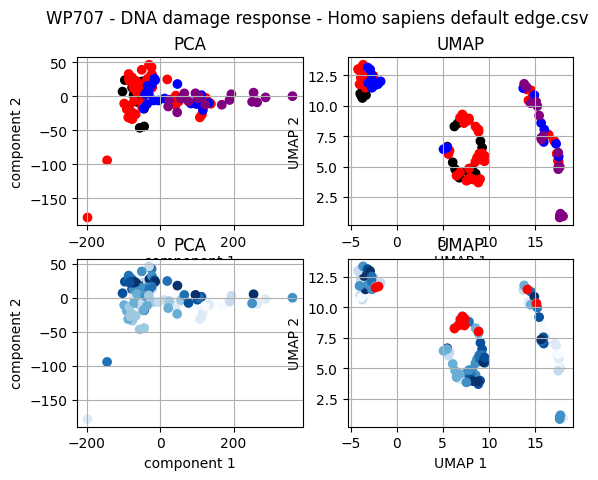

<Figure size 800x600 with 0 Axes>

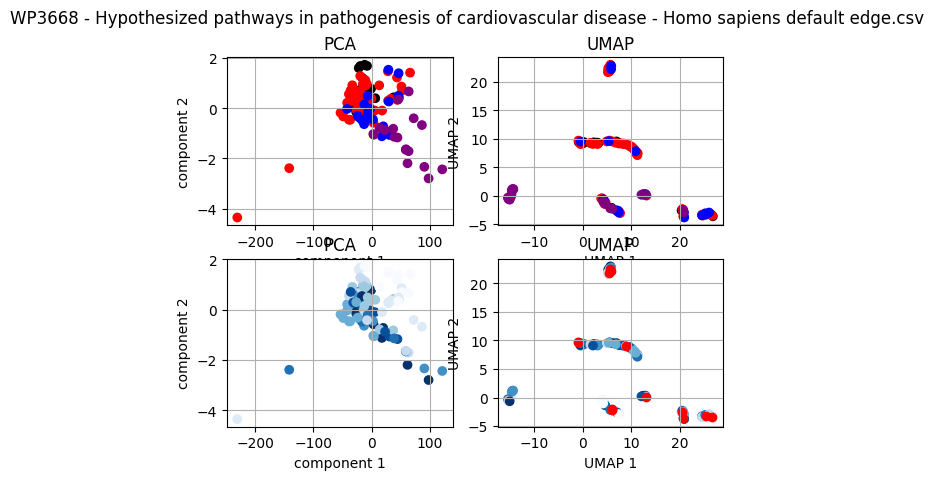

<Figure size 800x600 with 0 Axes>

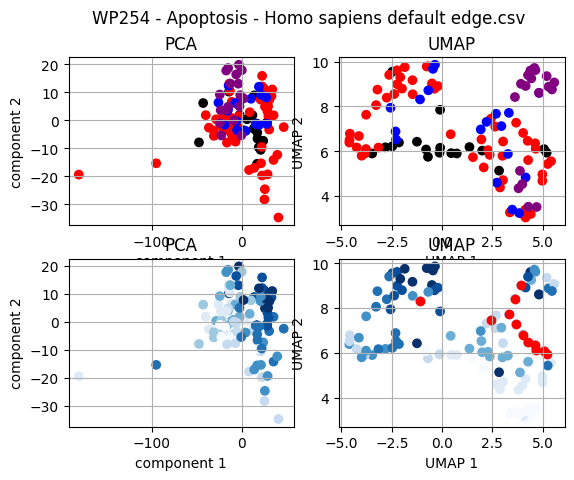

<Figure size 800x600 with 0 Axes>

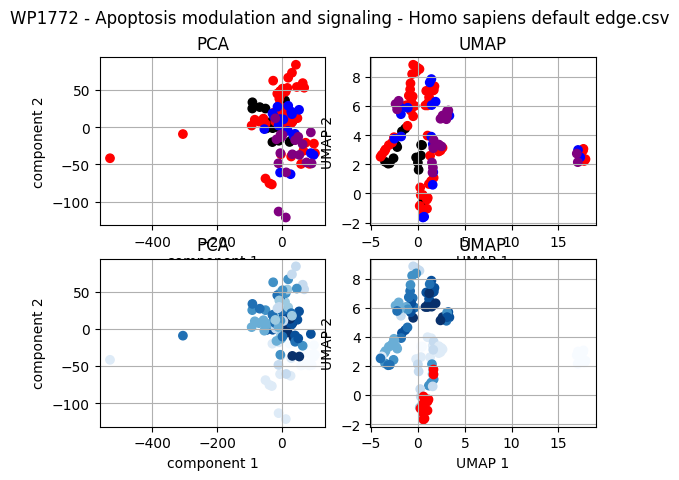

<Figure size 800x600 with 0 Axes>

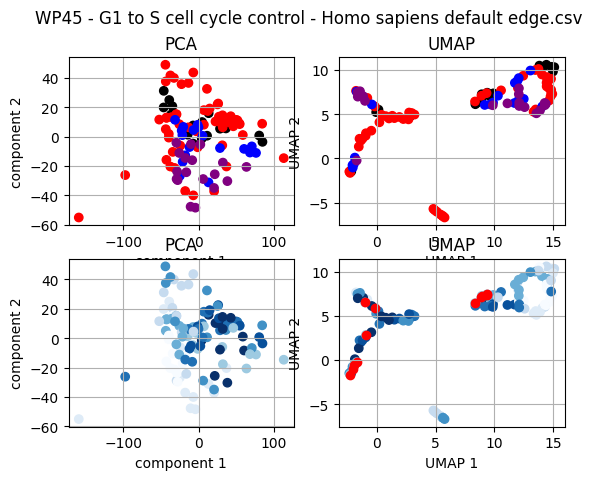

<Figure size 800x600 with 0 Axes>

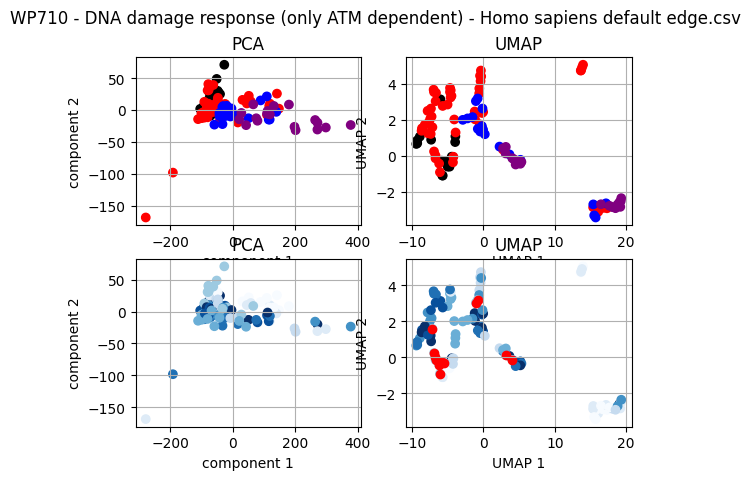

<Figure size 800x600 with 0 Axes>

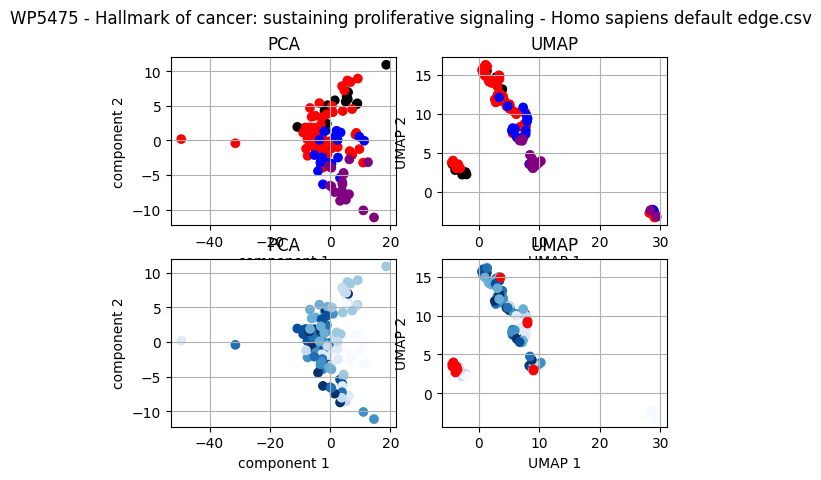

<Figure size 800x600 with 0 Axes>

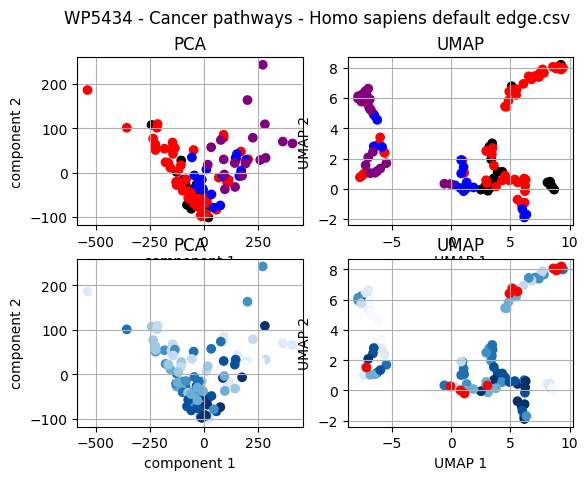

<Figure size 800x600 with 0 Axes>

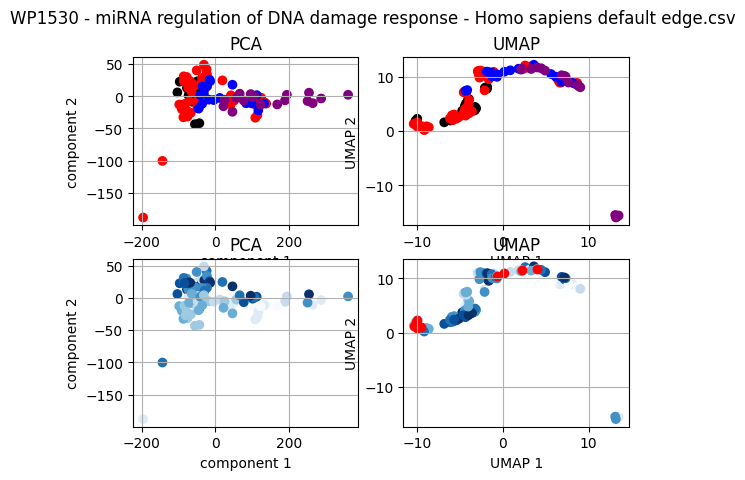

<Figure size 800x600 with 0 Axes>

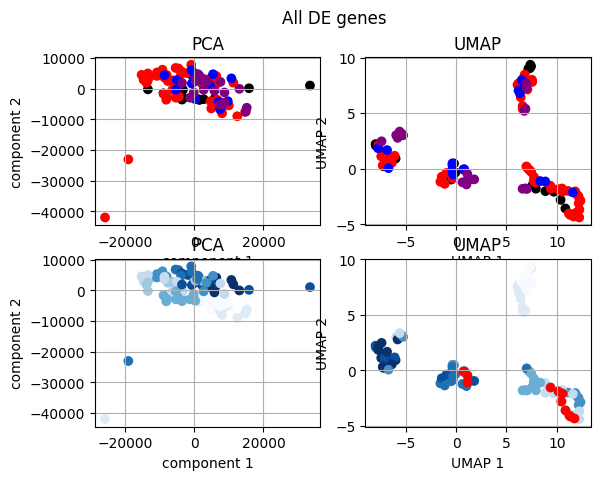

<Figure size 800x600 with 0 Axes>

In [85]:
WP_dir = pathlib.Path('/homes/shahashka/lucid_cd/data/prior_knowledge/WPs/')
WP_files = [p for p in WP_dir.iterdir() if p.is_file()]

for file in WP_files:
    pathway_genes = set()
    pathway = pd.read_csv(file, header=0)["name"]
    pathway_edges_split = [re.split(r'[()]', data) for data in pathway ]
    pathway_edges = [(data[0].replace(" ",""), data[-1].replace(" ","")) for data in pathway_edges_split ]
    pathway_edges_in_data = [edge for edge in pathway_edges if (edge[0] in df.columns) and (edge[1] in df.columns)]
    for edge in pathway_edges_in_data:
        pathway_genes.add(edge[0])
        pathway_genes.add(edge[1])
    if len(pathway_genes) > 0:
        fig, axs = plt.subplots(2,2)
        pathway_genes = list(pathway_genes)
        pca_plot(df, pathway_genes, axs[:,0])
        umap_plot(df, pathway_genes, axs[:,1])
        fig.suptitle(file.name)

fig, axs = plt.subplots(2,2)
pathway_genes = df.columns.drop(["dose_rate", "week"])
pca_plot(df, pathway_genes, axs[:,0])
umap_plot(df, pathway_genes, axs[:,1])
fig.suptitle("All DE genes")



Try scVI autoencoder framework for learning good embedding vectors

In [71]:
import os
import tempfile

import scanpy as sc
import scvi
import seaborn as sns
import torch
import anndata as ad


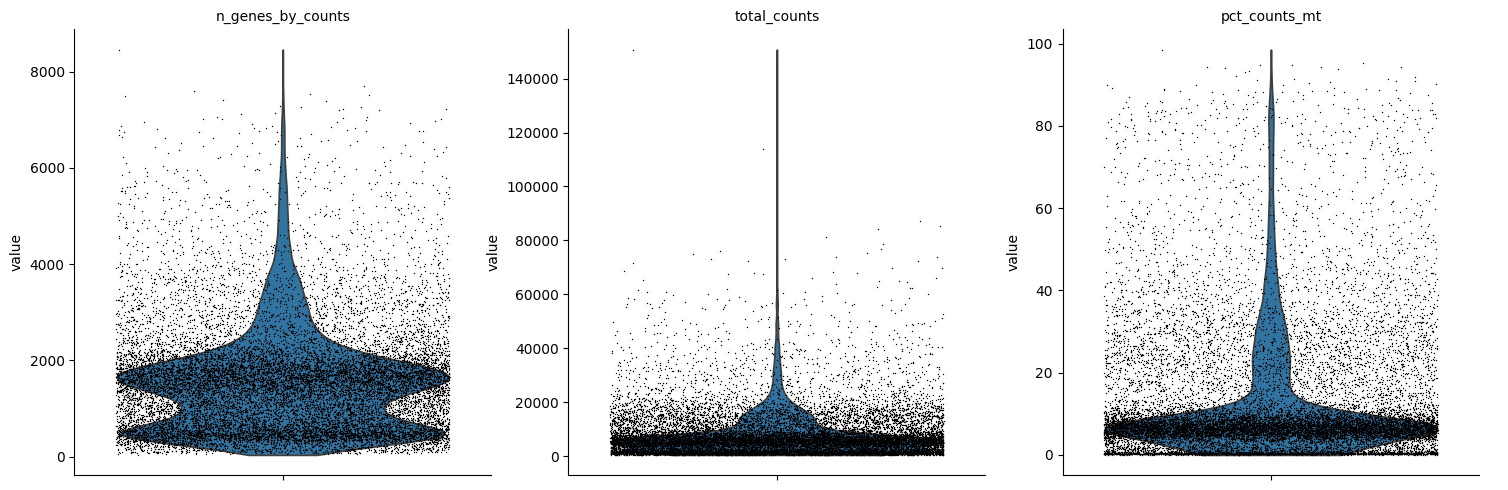

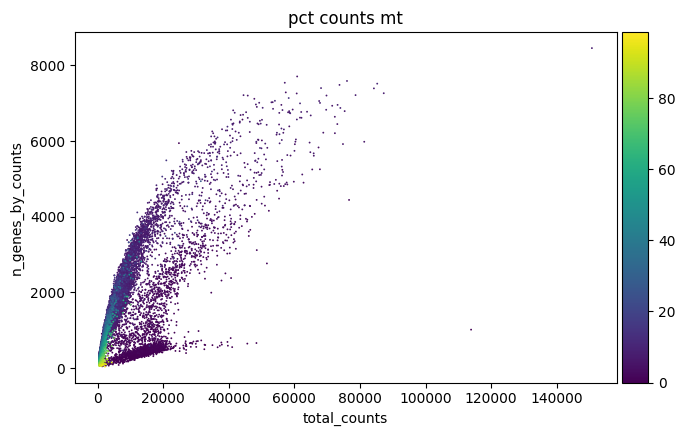

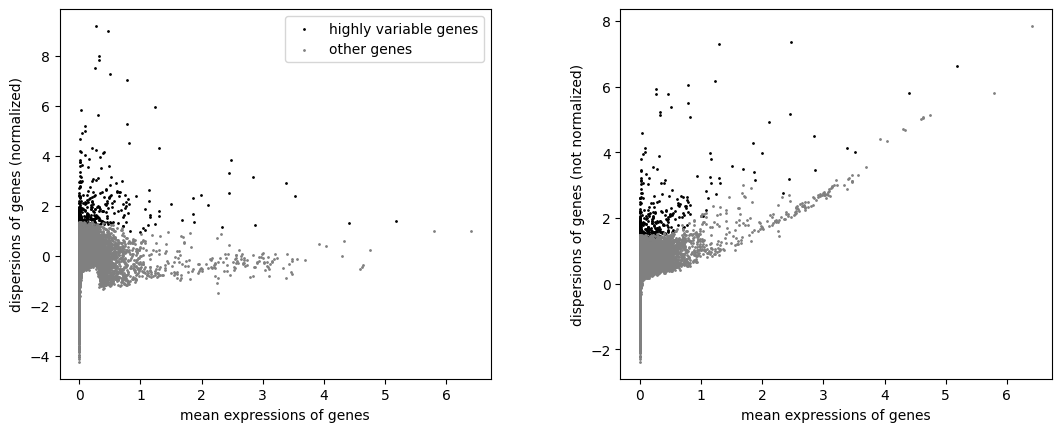

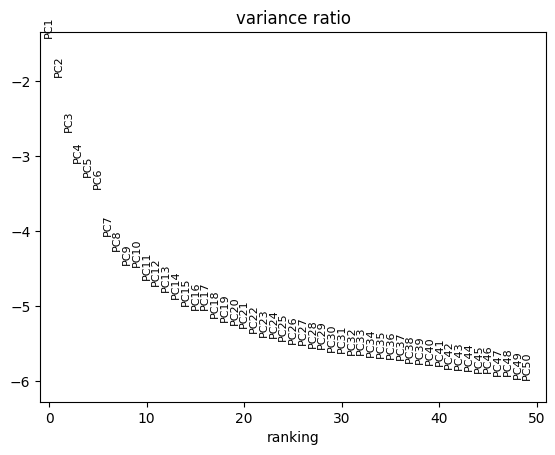

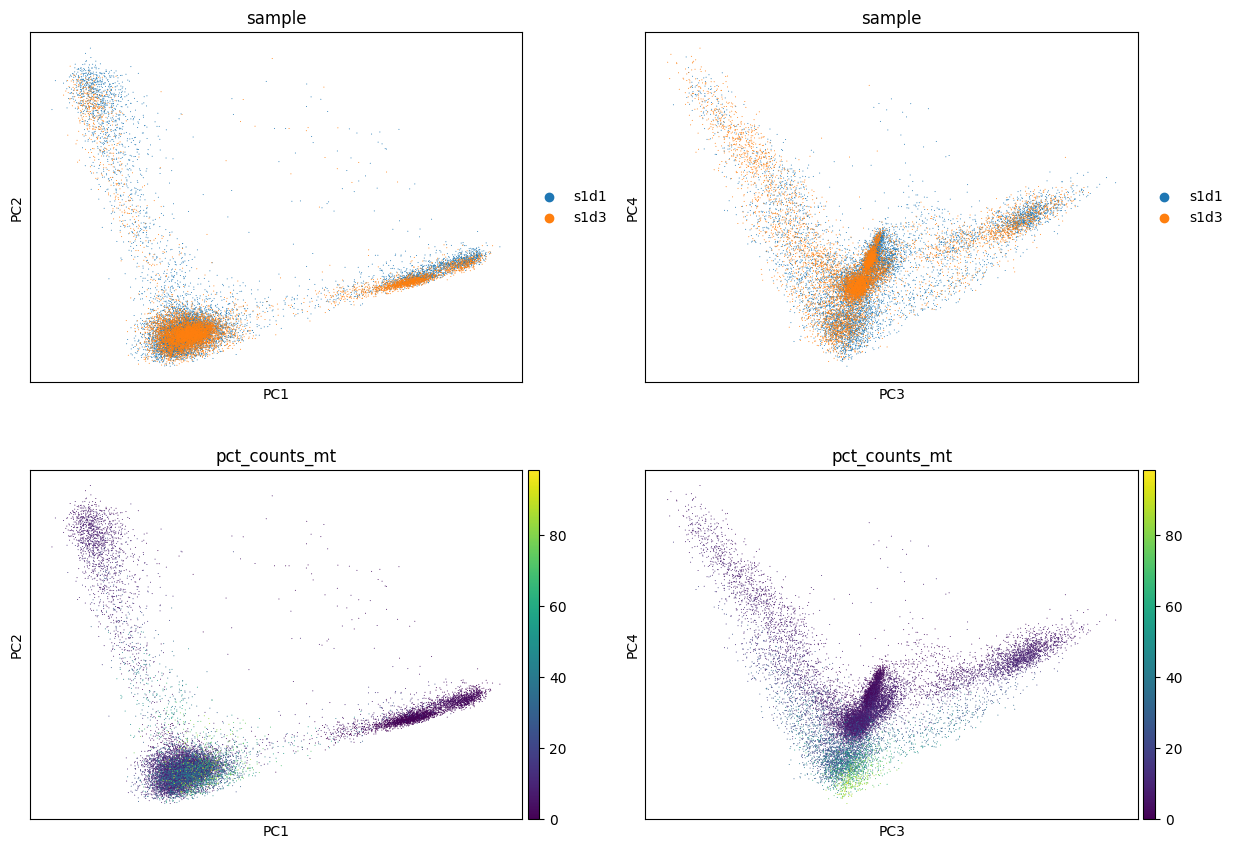

In [72]:
import pooch
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata_sc = ad.concat(adatas, label="sample")
adata_sc.obs_names_make_unique()


# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata_sc.var["mt"] = adata_sc.var_names.str.startswith("MT-")
# ribosomal genes
adata_sc.var["ribo"] = adata_sc.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata_sc.var["hb"] = adata_sc.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata_sc, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

sc.pl.violin(
    adata_sc,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

sc.pl.scatter(adata_sc, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

# Normalizing to median total counts
sc.pp.normalize_total(adata_sc)
# Logarithmize the data
sc.pp.log1p(adata_sc)
n_top_genes_sc = 800
sc.pp.highly_variable_genes(adata_sc, n_top_genes=n_top_genes_sc, batch_key="sample")
sc.pl.highly_variable_genes(adata_sc)

sc.tl.pca(adata_sc)
sc.pl.pca_variance_ratio(adata_sc, n_pcs=50, log=True)
sc.pl.pca(
    adata_sc,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

In [73]:
from sklearn.preprocessing import LabelEncoder
y_sc = adata_sc.obs['sample'].to_numpy()
y_sc = LabelEncoder().fit_transform(y_sc)
print(y_sc)
hv_genes_sc = []
for i, val in adata_sc.var['highly_variable'].items():
    if val:
        hv_genes_sc.append(i)
len(hv_genes_sc)
var_names_sc = list(adata_sc.var_names)
hv_ids = [var_names_sc.index(i) for i in hv_genes_sc]
print(len(var_names_sc), adata_sc.X.shape)
adata_sc.X[:,hv_ids].todense().shape

[0 0 0 ... 1 1 1]
36601 (17125, 36601)


(17125, 800)

(108, 11896)
(108, 11645)


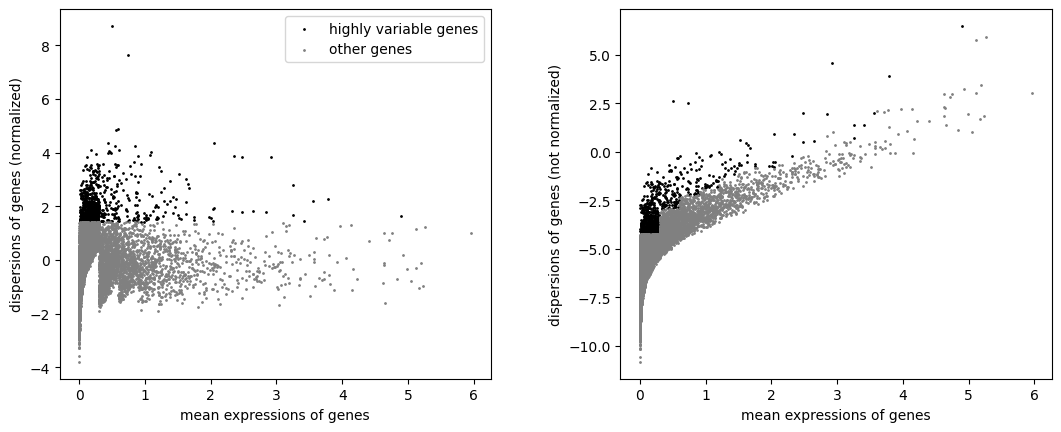

AnnData object with n_obs × n_vars = 108 × 11645
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
dose_rate
0.0      18
0.004    18
0.04     18
0.4      18
4.0      18
8.0      18
Name: count, dtype: int64
week
4    12
5    12
2    12
8    12
9    12
3    12
1    12
6    12
7    12
Name: count, dtype: int64


In [74]:

adata = sc.read(filename="/homes/shahashka/lucid_cd/data/rpe1_experiment2/cd_tpm_matrix_combined.csv")
print(adata.X.shape)
sc.pp.filter_genes(adata, min_counts=3)
print(adata.X.shape)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=800)
sc.pl.highly_variable_genes(adata)
print(adata)
adata.obs['dose_rate'] = [str(i) for i in df['dose_rate']]
adata.obs['week'] = [str(i) for i in df['week']]
print(adata.obs["dose_rate"].value_counts())
print(adata.obs["week"].value_counts())

# adatas = {}
# for d in ["F", "G", "H", "I", "J"]:
#     sample_adata = sc.read(filename=f"/homes/shahashka/lucid_cd/data/rpe1_experiment2/cd_tpm_matrix_d{d}.csv")
#     sample_adata.var_names_make_unique()
#     adatas[d] = sample_adata
# adata = ad.concat(adatas, label="dose_rate")
# adata.obs_names_make_unique()
# print(adata.obs["dose_rate"].value_counts())
# sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="dose_rate")
# # Normalizing to median total counts
# sc.pp.normalize_total(adata)
# # Logarithmize the data
# sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="dose_rate")
# sc.pl.highly_variable_genes(adata)



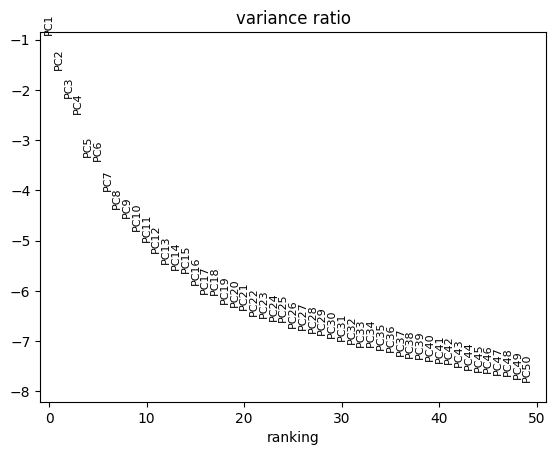

In [75]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

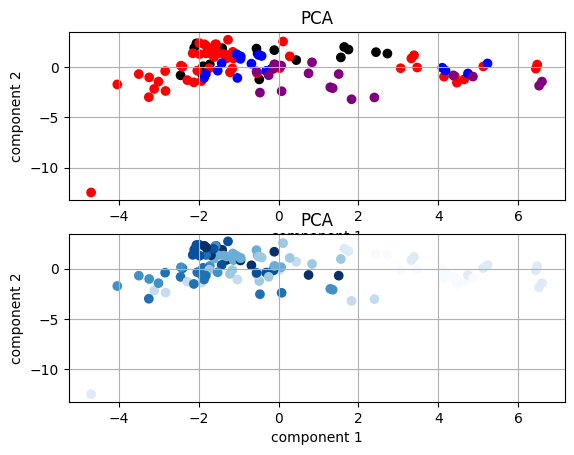

In [76]:
fig, axs = plt.subplots(2)
axs[0].scatter(adata.obsm["X_pca"][:,0], adata.obsm["X_pca"][:,1], c=[color_map[dr] for dr in df['dose_rate']])
axs[1].scatter(adata.obsm["X_pca"][:,0], adata.obsm["X_pca"][:,1],  c=df['week'], cmap='Blues')

for ax in axs:
    ax.set_title("PCA")
    ax.set_xlabel("component 1")
    ax.set_ylabel("component 2")
    ax.grid(True)


AxisArrays with keys: X_pca, X_umap


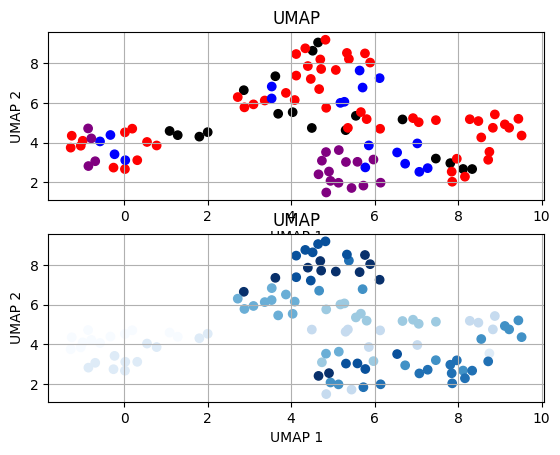

In [77]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
print(adata.obsm)
fig, axs = plt.subplots(2)

axs[0].scatter(adata.obsm["X_umap"][:,0], adata.obsm["X_umap"][:,1], c=[color_map[dr] for dr in df['dose_rate']])
axs[1].scatter(adata.obsm["X_umap"][:,0], adata.obsm["X_umap"][:,1],  c=df['week'], cmap='Blues')

for ax in axs:
    ax.set_title("UMAP")
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    ax.grid(True)

In [11]:
hv_genes = []
for i, val in adata.var['highly_variable'].items():
    if val:
        hv_genes.append(i)
len(hv_genes)

800

In [12]:
var_names = list(adata.var_names)
hv_ids = [var_names.index(i) for i in hv_genes]
print(len(var_names), adata.X.shape)
adata.X[:,hv_ids]

11645 (108, 11645)


array([[0.12334049, 0.11344586, 0.17219429, ..., 0.29056093, 0.4625033 ,
        1.1974349 ],
       [0.20558818, 0.29367006, 0.23749165, ..., 0.28953764, 0.7052857 ,
        0.9879868 ],
       [0.13900588, 0.30002278, 0.2514958 , ..., 0.36891735, 0.76196957,
        0.77153593],
       ...,
       [0.2639134 , 0.25847775, 0.16167168, ..., 0.2310515 , 0.6289803 ,
        0.7556146 ],
       [0.21608083, 0.27270472, 0.13805018, ..., 0.25420794, 0.57842577,
        0.787354  ],
       [0.20129848, 0.18786488, 0.12175995, ..., 0.1322533 , 0.488373  ,
        0.64672923]], dtype=float32)

In [13]:
cd_genes = pd.read_csv("./data/rpe1_experiment2/bootstrap_graphs3/rad_sub_dag_gnn_combined.csv", header=None).iloc[:,0].to_list()
len(cd_genes)

374

In [14]:
len(set(hv_genes).intersection(set(cd_genes)))

33

## Train autoencoder

In [15]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder


In [47]:
# Model Hyperparameters
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 64
x_dim  = n_top_genes_sc
hidden_dim = 400
latent_dim = 200
gamma = 0.9

lr = 1e-3
epochs = 40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} 

In [62]:
class DoseRateGeneExpressionDataset(Dataset):
    def __init__(self, X, y):
        self.data = torch.from_numpy(X)
        self.targets = torch.from_numpy(y)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

#full_dataset = DoseRateGeneExpressionDataset(df_genes.to_numpy(), df['dose_rate'].to_numpy())
X = np.array(adata.X[:,hv_ids], dtype=np.float32)
#X = np.array(adata_sc.X[:,hv_ids].todense(), dtype=np.float32)
X = MinMaxScaler().fit_transform(X)
y = OneHotEncoder().fit_transform(df['dose_rate'].to_numpy(dtype=np.float32).reshape(-1,1)).todense()
#y = np.array(OneHotEncoder().fit_transform(y_sc.reshape(-1,1)).todense(), dtype=np.float32)
hv_dataset = DoseRateGeneExpressionDataset(X,y )
train_size = int(len(hv_dataset) * 0.8)
test_size = len(hv_dataset) - train_size

# torch.manual_seed(42)
train_dataset, test_dataset = random_split(hv_dataset, [train_size, test_size])

full_loader = train_loader = DataLoader(hv_dataset, batch_size=batch_size, shuffle=True, **kwargs)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

Training set size: 86
Testing set size: 22


In [56]:
# f = wx + b, sigmoid at the end
class LogisticRegression(nn.Module):

    def __init__(self, n_input_features):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_predicted = torch.sigmoid(self.linear(x))
        return y_predicted
    
class Classifier(nn.Module):
    def __init__(self, n_input_features, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(n_input_features, num_classes)
    def forward(self, mu):
        return self.fc(mu)
    
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        #x_hat = torch.sigmoid(self.FC_output(h))
        x_hat = self.FC_output(h)
        return x_hat
    
class VAE(nn.Module):
    def __init__(self, Encoder, Decoder):#, Classifier):
        super(VAE, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        #self.Classifier = Classifier
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        #y_logits = self.Classifier(mean)
        
        return x_hat, mean, log_var #, y_logits

In [57]:
from torch.optim import Adam
BCE_loss = nn.BCELoss()

def loss_function(x, x_hat,  mean, log_var): # y, y_hat, 
    #classifier_loss = nn.functional.cross_entropy(y_hat, y)
    reproduction_loss = nn.functional.binary_cross_entropy_with_logits(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD #+ gamma *classifier_loss


In [58]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)
#classifier = LogisticRegression(latent_dim)
classifier = Classifier(latent_dim, num_classes=2)
model = VAE(Encoder=encoder, Decoder=decoder).to(DEVICE)#, Classifier=classifier).to(DEVICE)
optimizer = Adam(model.parameters(), lr=lr)

print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        #x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var= model(x) #, y_hat 
        # x = torch.clamp(x, 1e-6, 1 - 1e-6)
        # y = torch.clamp(y, 1e-6, 1 - 1e-6)
        loss = loss_function(x, x_hat, mean, log_var) #y, y_hat,
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...


	Epoch 1 complete! 	Average Loss:  745.6794281005859
	Epoch 2 complete! 	Average Loss:  731.1998138427734
	Epoch 3 complete! 	Average Loss:  713.0188751220703
	Epoch 4 complete! 	Average Loss:  695.7223815917969
	Epoch 5 complete! 	Average Loss:  688.5334625244141
	Epoch 6 complete! 	Average Loss:  687.4943389892578
	Epoch 7 complete! 	Average Loss:  683.4895935058594
	Epoch 8 complete! 	Average Loss:  683.2147521972656
	Epoch 9 complete! 	Average Loss:  679.1339263916016
	Epoch 10 complete! 	Average Loss:  677.5295867919922
	Epoch 11 complete! 	Average Loss:  678.0415802001953
	Epoch 12 complete! 	Average Loss:  677.4047393798828
	Epoch 13 complete! 	Average Loss:  675.1882019042969
	Epoch 14 complete! 	Average Loss:  674.8317108154297
	Epoch 15 complete! 	Average Loss:  673.8678588867188
	Epoch 16 complete! 	Average Loss:  671.3437805175781
	Epoch 17 complete! 	Average Loss:  669.7782287597656
	Epoch 18 complete! 	Average Loss:  668.5076599121094
	Epoch 19 complete! 	Average Loss:  6

{0: 'black', 1: 'red', 2: 'red', 3: 'red', 4: 'blue', 5: 'purple'}


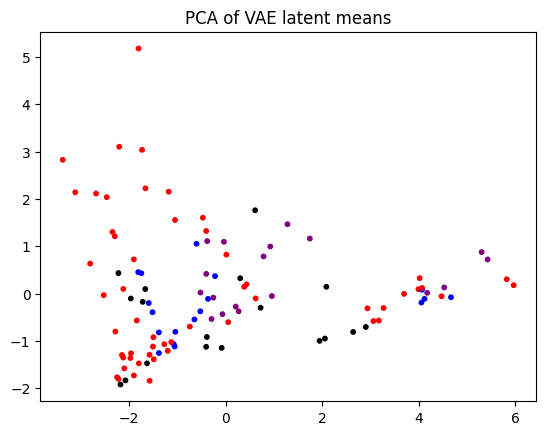

In [78]:
# Visualize latent vectors
Z = []
Y = []

with torch.no_grad():
    for x, y in full_loader:
        mu, logvar = encoder(x.to(device))
        Z.append(mu.cpu())
        Y.append(y)

Z = torch.cat(Z).numpy()
Y = torch.cat(Y).numpy()
#dose_rates = np.sort(list(set(Y)))
dose_rates = [np.argmax(i).item() for i in Y]
#colors = ['black', 'red', 'orange', 'green', 'blue', 'purple']
colors = ['black', 'red', 'red', 'red', 'blue', 'purple']
color_map = dict(zip(np.sort(list(set(dose_rates))), colors))
print(color_map)
Z_pca = PCA(n_components=10).fit_transform(Z)
#plt.scatter(Z_pca[:, 0], Z_pca[:, 1], c=dose_rates, cmap='Blues', s=10)
plt.scatter(Z_pca[:, 0], Z_pca[:, 1], c=[color_map[d]for d in dose_rates], s=10)

#plt.scatter(Z_pca[:, 0], Z_pca[:, 1], c=y_sc, s=10)

plt.title("PCA of VAE latent means")
plt.show()


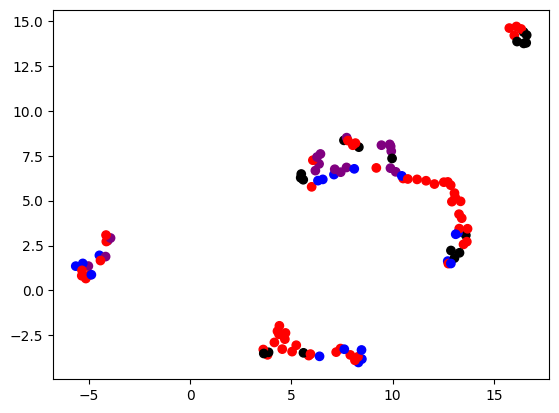

In [79]:
embedding_2d = reducer.fit_transform(Z)
# kmeans = KMeans(n_clusters=3)
# cluster_ids = kmeans.fit_predict(embedding_2d)

#plt.scatter(embedding_2d[:,0], embedding_2d[:,1],c=dose_rates, cmap='Blues')#c=[colors[y] for y in dose_rates]) # alpha=df['week']/10,
plt.scatter(embedding_2d[:,0], embedding_2d[:,1],c=[color_map[d]for d in dose_rates])

In [23]:
preds = Y.argmax(axis=1)
y = OneHotEncoder().fit_transform(df['week'].to_numpy(dtype=np.float32).reshape(-1,1)).todense()
y_labels = y.argmax(axis=1)
print(preds.shape, y_labels.shape)
acc = np.sum(preds == y_labels.flatten())/len(preds)
print("latent classifier acc:", acc)

(108,) (108, 1)
latent classifier acc: 0.1111111111111111
